http://digital-thinking.de/tensorflow-vs-keras-or-how-to-speed-up-your-training-for-image-data-sets-by-factor-10/

In [1]:
%matplotlib inline

import keras
import os
import json
import multiprocessing
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np


from PIL import Image
from tensorflow.python.ops import array_ops
from tqdm.notebook import tqdm
from random import shuffle
from glob import glob
from datetime import datetime


from keras import backend as K
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Cropping2D, Lambda, GlobalAveragePooling2D,BatchNormalization,AveragePooling2D
from keras.models import Sequential,Model
from keras.optimizers import SGD, rmsprop, Adam
from keras.metrics import categorical_accuracy, categorical_crossentropy, top_k_categorical_accuracy
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model, model_from_json
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, hamming_loss

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def hn_multilabel_loss(y_true, y_pred):
    # Avoid divide by 0
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    # Multi-task loss
    return K.mean(K.sum(- y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred), axis=1))


Using TensorFlow backend.


In [2]:
train_path = "C:/Users/mbura/Desktop/train/"
val_path = "C:/Users/mbura/Desktop/validation/"

train_files = [train_path + path for path in os.listdir(train_path) if "X_train" in path]
val_files = [val_path + path for path in os.listdir(val_path) if "X_val" in path]

batches = np.arange(15)*20 + 20
datamap = {train_path + "X_train_batch{}.npy".format(i): train_path + "y_train_batch{}.npy".format(i) for i in batches}

In [3]:
val_datamap = {val_path + "X_val_batch20.npy": val_path + "y_val_batch20.npy"}

In [4]:
datamap.update(val_datamap)
datamap

{'C:/Users/mbura/Desktop/train/X_train_batch20.npy': 'C:/Users/mbura/Desktop/train/y_train_batch20.npy',
 'C:/Users/mbura/Desktop/train/X_train_batch40.npy': 'C:/Users/mbura/Desktop/train/y_train_batch40.npy',
 'C:/Users/mbura/Desktop/train/X_train_batch60.npy': 'C:/Users/mbura/Desktop/train/y_train_batch60.npy',
 'C:/Users/mbura/Desktop/train/X_train_batch80.npy': 'C:/Users/mbura/Desktop/train/y_train_batch80.npy',
 'C:/Users/mbura/Desktop/train/X_train_batch100.npy': 'C:/Users/mbura/Desktop/train/y_train_batch100.npy',
 'C:/Users/mbura/Desktop/train/X_train_batch120.npy': 'C:/Users/mbura/Desktop/train/y_train_batch120.npy',
 'C:/Users/mbura/Desktop/train/X_train_batch140.npy': 'C:/Users/mbura/Desktop/train/y_train_batch140.npy',
 'C:/Users/mbura/Desktop/train/X_train_batch160.npy': 'C:/Users/mbura/Desktop/train/y_train_batch160.npy',
 'C:/Users/mbura/Desktop/train/X_train_batch180.npy': 'C:/Users/mbura/Desktop/train/y_train_batch180.npy',
 'C:/Users/mbura/Desktop/train/X_train_batch2

#### Parameters

In [5]:
WIDTH = 480
HEIGHT = 270
LR = 1e-3
EPOCHS = 30
TEST_SIZE = .2
BS = 8

#### Read data path

In [6]:
MODEL_NAME = 'fourth_batch_model'

target_names = ['W','S','A','D']

#### Check dataset randomly

In [7]:
idx = np.random.randint(len(batches))
print("\nIndex: ", idx)

X = np.load(train_files[idx])
y = np.load(datamap[train_files[idx]])
y = y[:,:4]


Index:  2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


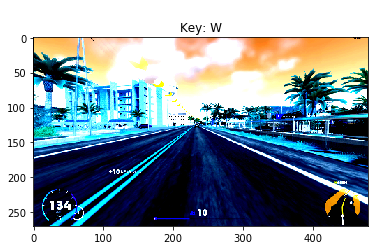

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


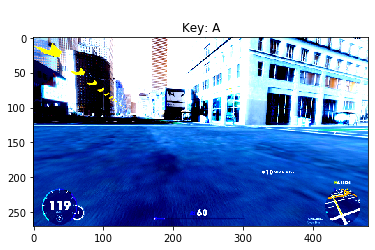

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


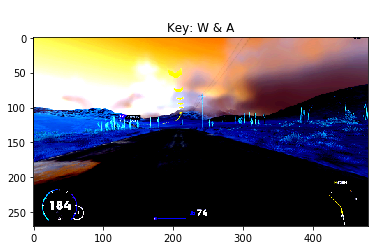

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


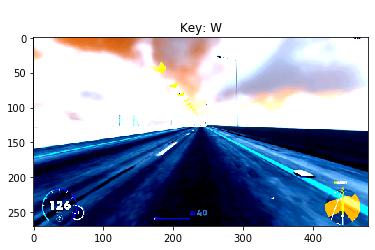

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


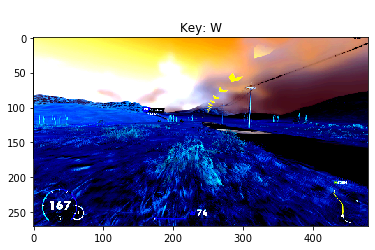

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


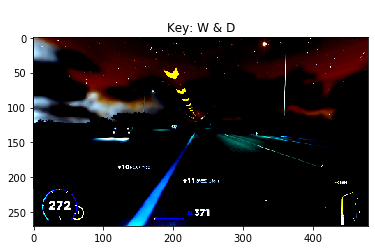

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


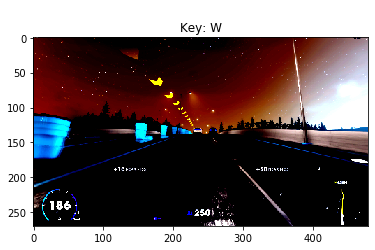

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


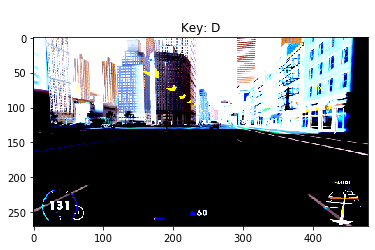

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


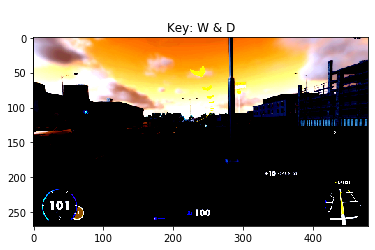

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


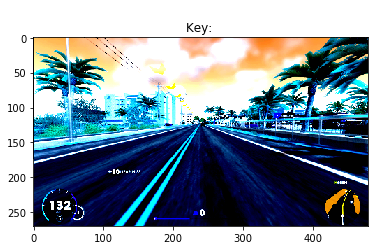

In [8]:
for i in range(10):
    idx = np.random.randint(5000)
    plt.imshow(X[idx])
    plt.title("\nKey: " + " & ".join([target_names[id] for id, key in enumerate(y[idx]) if key==1.]))
    plt.show()

In [9]:
del X, y

#### Define Model

In [10]:
base_model = MobileNetV2(include_top=False, weights='imagenet',
                         input_shape=(HEIGHT, WIDTH, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
# Lowered dropout rate
x = Dropout(.1)(x)                     

predictions = Dense(4, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

## Init with imagenet & finetune:

for layer in model.layers:  
    layer.trainable = True

model.compile(optimizer=Adam(lr=1e-3, decay=1e-9), loss='binary_crossentropy', metrics=["accuracy", hn_multilabel_loss])

c:\users\mbura\appdata\local\programs\python\python36\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


#### Training

In [11]:
loss = []
val_loss = []

for epoch in range(EPOCHS):
    for count, file in enumerate(train_files):
        
        X = np.load(file)
        y = np.load(datamap[file])
        y = y[:,:4]
        
        print('\nLoaded file: ' + file+ ", Length: " +str(len(X)) + "\n")
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

        H = model.fit(X_train, y_train,
                    batch_size = BS,
                    epochs = 1,
                    validation_data=(X_val, y_val))

        loss.append(H.history["loss"])
        val_loss.append(H.history["val_loss"])
        print("\nBatch {} is finished.\n".format(count))
        
    print("\nEpoch {} - Saving Model.\n".format(epoch))
    model.save_weights(MODEL_NAME + '_Epoch_{}.h5'.format(epoch))
    model_json = model.to_json()
    with open(MODEL_NAME + '_Epoch_{}_'.format(epoch) + "json.json", "w") as json_file:
        json.dump(model_json, json_file)



Loaded file: C:/Users/mbura/Desktop/train/X_train_batch100.npy, Length: 5000

Train on 4000 samples, validate on 1000 samples
Epoch 1/1
4000/4000 [==============================] - 165s 41ms/step - loss: 0.4024 - acc: 0.8282 - hn_multilabel_loss: 1.6094 - val_loss: 1.5172 - val_acc: 0.8207 - val_hn_multilabel_loss: 6.0688

Batch 0 is finished.


Loaded file: C:/Users/mbura/Desktop/train/X_train_batch120.npy, Length: 5000

Train on 4000 samples, validate on 1000 samples
Epoch 1/1
4000/4000 [==============================] - 165s 41ms/step - loss: 0.2443 - acc: 0.9079 - hn_multilabel_loss: 0.9773 - val_loss: 0.7338 - val_acc: 0.8790 - val_hn_multilabel_loss: 2.9354

Batch 1 is finished.


Loaded file: C:/Users/mbura/Desktop/train/X_train_batch140.npy, Length: 5000

Train on 4000 samples, validate on 1000 samples
Epoch 1/1
4000/4000 [==============================] - 150s 37ms/step - loss: 0.3088 - acc: 0.8746 - hn_multilabel_loss: 1.2350 - val_loss: 4.0245 - val_acc: 0.6953 - val_hn_mul

KeyboardInterrupt: 

## Validation results

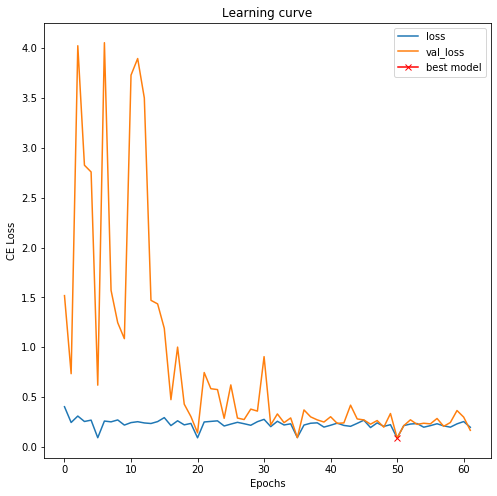

In [12]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(loss, label="loss")
plt.plot(val_loss, label="val_loss")
plt.plot(np.argmin(val_loss), np.min(val_loss), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("CE Loss")
plt.legend()
plt.show()

In [22]:
print(np.argmin(val_loss)), len(val_loss)

50


(None, 62)

In [20]:
X_val = np.load(val_files[0])
y_val = np.load(datamap[val_files[0]]) 
y_val = y_val[:,:4]

In [21]:
out = model.predict(X_val)
y_pred1 = (out > 0.5) 
hamming_loss(y_val, y_pred1)

0.1762820512820513

#### For tensorboard: $ tensorboard --logdir=logs/

In [ ]:
# Check class distributions

# total_val = pd.DataFrame([], columns = ["val"])
# for path in train_paths:
#     df = np.load(path)
#     df_label = [target_names[np.argmax(i[1],axis=-1)] for i in df] 
#     total_ = pd.DataFrame(df_label,columns=["val"])
#     print(total_.val.value_counts())
#     print("\n")
#     total_val = pd.concat([total_val, total_])

In [ ]:
# Load last model
# model.load_weights('first_batch_model_Epoch_7.h5')

#### Save Model

In [ ]:
# model.save_weights(MODEL_NAME + '.h5')
# model_json = model.to_json()

# with open(MODEL_NAME +  ".json", "w") as json_file:
#     json.dump(model_json, json_file)